In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
samples = []
with open('/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [3]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [4]:
len(samples)

7970

In [7]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = '/data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

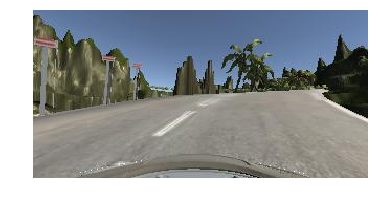

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
image1 = '/data/IMG/' + samples[6000][0].split('/')[-1]
center_image = cv2.imread(image1)
center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(center_image)

In [9]:
center_image.shape

(160, 320, 3)

In [10]:
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25), (0,0))))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  """
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  


In [13]:
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples = len(validation_samples), nb_epoch=5, verbose=1)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=6376, validation_steps=1594, verbose=1, epochs=5, validation_data=<generator...)`
  """Entry point for launching an IPython kernel.


Epoch 1/5
6376/6376 [==============================] - 375s - loss: 0.0268 - val_loss: 0.0468
Epoch 2/5
6376/6376 [==============================] - 284s - loss: 0.0105 - val_loss: 0.0426
Epoch 3/5
6376/6376 [==============================] - 283s - loss: 0.0086 - val_loss: 0.0437
Epoch 4/5
6376/6376 [==============================] - 283s - loss: 0.0079 - val_loss: 0.0415
Epoch 5/5
6376/6376 [==============================] - 283s - loss: 0.0070 - val_loss: 0.0427


In [ ]:
model.save('model.h5')

In [ ]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()